In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("SparkMLLib").getOrCreate()


data = spark.read.format("csv")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .load("/home/duytri/Desktop/data_geo.csv")

data.cache()

data.count()

294

In [2]:
display(data)

data.printSchema()

DataFrame[2014 rank: int, City: string, State: string, State Code: string, 2014 Population estimate: int, 2015 median sales price: double]

root
 |-- 2014 rank: integer (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- State Code: string (nullable = true)
 |-- 2014 Population estimate: integer (nullable = true)
 |-- 2015 median sales price: double (nullable = true)



In [3]:
data = data.dropna()
data.count()

109

In [4]:
data.show()

+---------+-----------------+-----------+----------+------------------------+-----------------------+
|2014 rank|             City|      State|State Code|2014 Population estimate|2015 median sales price|
+---------+-----------------+-----------+----------+------------------------+-----------------------+
|      101|       Birmingham|    Alabama|        AL|                  212247|                  162.9|
|      125|       Huntsville|    Alabama|        AL|                  188226|                  157.7|
|      122|           Mobile|    Alabama|        AL|                  194675|                  122.5|
|      114|       Montgomery|    Alabama|        AL|                  200481|                  129.0|
|        6|          Phoenix|    Arizona|        AZ|                 1537058|                  206.1|
|       33|           Tucson|    Arizona|        AZ|                  527972|                  178.1|
|      119|      Little Rock|   Arkansas|        AR|                  197706|     

In [5]:
data.createOrReplaceTempView("data_geo")
df1 = spark.sql("select City, `State Code`, `2014 Population estimate`/1000 as `2014 Pop estimate`,"
                "`2015 median sales price` from data_geo")

df1.show()

df2 = spark.sql("select `2014 Population estimate`,`2015 median sales price` as label from data_geo")

df2.show()

+-----------------+----------+-----------------+-----------------------+
|             City|State Code|2014 Pop estimate|2015 median sales price|
+-----------------+----------+-----------------+-----------------------+
|       Birmingham|        AL|          212.247|                  162.9|
|       Huntsville|        AL|          188.226|                  157.7|
|           Mobile|        AL|          194.675|                  122.5|
|       Montgomery|        AL|          200.481|                  129.0|
|          Phoenix|        AZ|         1537.058|                  206.1|
|           Tucson|        AZ|          527.972|                  178.1|
|      Little Rock|        AR|          197.706|                  131.8|
|          Anaheim|        CA|          346.997|                  685.7|
|      Los Angeles|        CA|         3928.864|                  434.7|
|        Riverside|        CA|          319.504|                  281.0|
|       Sacramento|        CA|          485.199|   

In [6]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["2014 Population estimate"],
    outputCol="features")
data = assembler.transform(df2)
display(data.select("features", "label"))

data.show()

DataFrame[features: vector, label: double]

+------------------------+-----+-----------+
|2014 Population estimate|label|   features|
+------------------------+-----+-----------+
|                  212247|162.9| [212247.0]|
|                  188226|157.7| [188226.0]|
|                  194675|122.5| [194675.0]|
|                  200481|129.0| [200481.0]|
|                 1537058|206.1|[1537058.0]|
|                  527972|178.1| [527972.0]|
|                  197706|131.8| [197706.0]|
|                  346997|685.7| [346997.0]|
|                 3928864|434.7|[3928864.0]|
|                  319504|281.0| [319504.0]|
|                  485199|275.8| [485199.0]|
|                 1381069|510.3|[1381069.0]|
|                  852469|748.3| [852469.0]|
|                 1015785|900.0|[1015785.0]|
|                  105112|442.2| [105112.0]|
|                  445830|220.1| [445830.0]|
|                  663862|338.1| [663862.0]|
|                  147612|342.7| [147612.0]|
|                  124705|202.6| [124705.0]|
|         

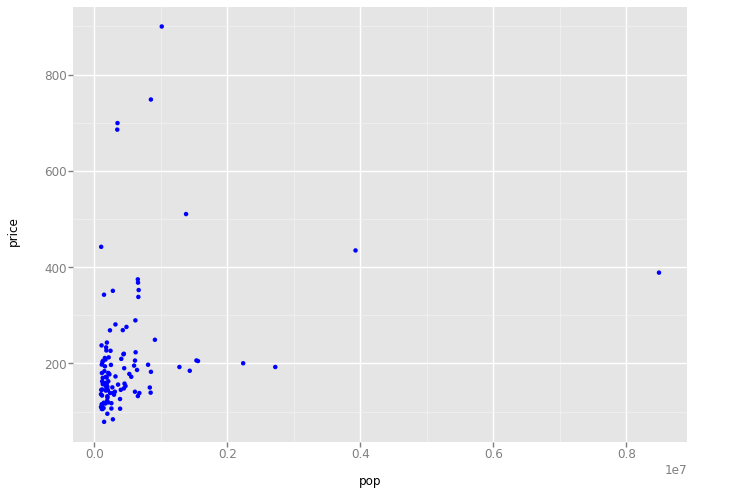

<ggplot: (-9223363302719819758)>

In [16]:
import matplotlib.pyplot as plt

x = data.rdd.map(lambda p: (p.features[0])).collect()
y = data.rdd.map(lambda p: (p.label)).collect()

from pandas import *
from ggplot import *

pydf = DataFrame({'pop': x, 'price': y})
p = ggplot(pydf, aes('pop', 'price')) + geom_point(color='blue')

display(p)

In [8]:
from pyspark.ml.regression import LinearRegression

#Tạo biến LinearRegression để sử dụng
lr = LinearRegression()

#Tạo ra hai mô hình tương ứng với hai tham số
modelA = lr.fit(data, {lr.regParam:0.0})
modelB = lr.fit(data, {lr.regParam:100.0})

In [9]:
#Hiển thị thông tin của hai mô hình
print(">>>> ModelA intercept: {}, coefficient: {}".format(modelA.intercept, modelA.coefficients[0]))
print(">>>> ModelB intercept: {}, coefficient: {}".format(modelB.intercept, modelB.coefficients[0]))

>>>> ModelA intercept: 191.29427575139394, coefficient: 3.779789682338248e-05
>>>> ModelB intercept: 199.85112564667153, coefficient: 2.1603499483717156e-05


In [10]:
#Hiển thị thông tin của hai mô hình
predictionsA = modelA.transform(data)
predictionsA.show()
predictionsB = modelB.transform(data)
predictionsB.show()


+------------------------+-----+-----------+------------------+
|2014 Population estimate|label|   features|        prediction|
+------------------------+-----+-----------+------------------+
|                  212247|162.9| [212247.0]| 199.3167659584664|
|                  188226|157.7| [188226.0]|198.40882267887193|
|                  194675|122.5| [194675.0]|198.65258131548592|
|                  200481|129.0| [200481.0]|198.87203590444247|
|                 1537058|206.1|[1537058.0]|249.39183544694856|
|                  527972|178.1| [527972.0]|211.25050693302884|
|                  197706|131.8| [197706.0]| 198.7671467407576|
|                  346997|685.7| [346997.0]| 204.4100325554172|
|                 3928864|434.7|[3928864.0]|339.79707185649573|
|                  319504|281.0| [319504.0]|203.37085497805194|
|                  485199|275.8| [485199.0]|209.63377749220228|
|                 1381069|510.3|[1381069.0]|243.49577931936597|
|                  852469|748.3| [852469

+------------------------+-----+-----------+------------------+
|2014 Population estimate|label|   features|        prediction|
+------------------------+-----+-----------+------------------+
|                  212247|162.9| [212247.0]|204.43640360159205|
|                  188226|157.7| [188226.0]|203.91746594049368|
|                  194675|122.5| [194675.0]|204.05678690866418|
|                  200481|129.0| [200481.0]|204.18221682666663|
|                 1537058|206.1|[1537058.0]|233.05695735611485|
|                  527972|178.1| [527972.0]|211.25716847608865|
|                  197706|131.8| [197706.0]|204.12226711559933|
|                  346997|685.7| [346997.0]|207.34747515702293|
|                 3928864|434.7|[3928864.0]|284.72833704226645|
|                  319504|281.0| [319504.0]| 206.7535301457171|
|                  485199|275.8| [485199.0]| 210.3331219926716|
|                 1381069|510.3|[1381069.0]| 229.6870490751493|
|                  852469|748.3| [852469

In [11]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(metricName="rmse")
RMSEA = evaluator.evaluate(predictionsA)
print("ModelA: Root Mean Squared Error = " + str(RMSEA))
RMSEB = evaluator.evaluate(predictionsB)
print("ModelB: Root Mean Squared Error = " + str(RMSEB))

ModelA: Root Mean Squared Error = 128.60202684284758
ModelB: Root Mean Squared Error = 129.49630019270606


In [12]:
from pandas import *

pop = data.rdd.map(lambda p: (p.features[0])).collect()
price = data.rdd.map(lambda p: (p.label)).collect()
predA = predictionsA.select("prediction").rdd.map(lambda r: r[0]).collect()
predB = predictionsB.select("prediction").rdd.map(lambda r: r[0]).collect()

pydf = DataFrame({'pop': pop, 'price': price, 'predA': predA, 'predB': predB})

#pydf

#pydf.to_csv("/home/duytri/Desktop/data_exported.csv")

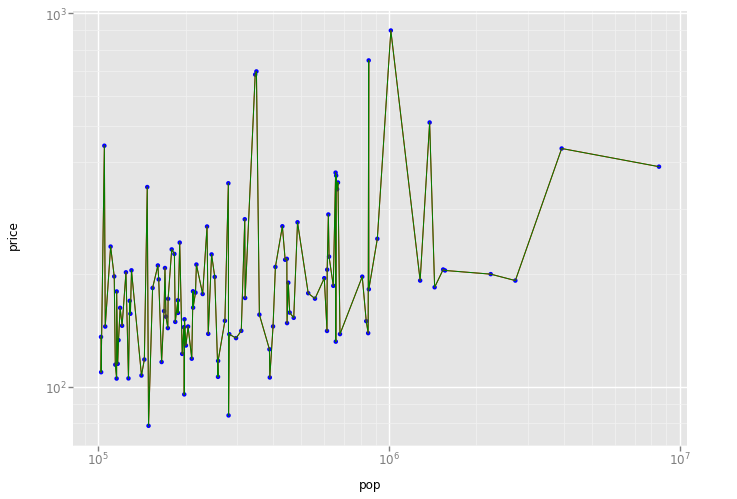

<ggplot: (8734135703658)>

In [13]:
from ggplot import *

p = ggplot(pydf, aes('pop', 'price'))\
    + geom_point(color='blue')\
    + geom_line(pydf, aes('pop', 'predA'), color='red')\
    + geom_line(pydf, aes('pop', 'predB'), color='green')\
    + scale_x_log()\
    + scale_y_log()
display(p)

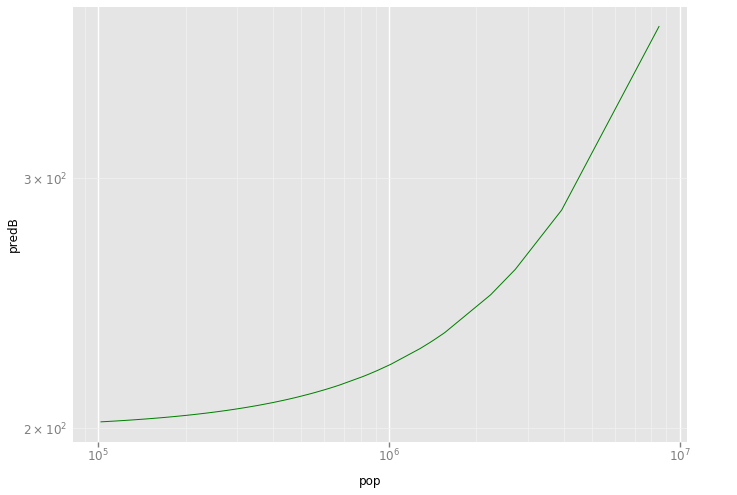

<ggplot: (8734135734483)>

In [14]:
t = ggplot(pydf, aes('pop', 'predB'))\
    + geom_line(pydf, aes('pop', 'predB'), color='green')\
    + scale_x_log()\
    + scale_y_log()
#    + geom_line(pydf, aes('pop', 'predA'), color='red')\
display(t)